# Construir um modelo de classificação: Deliciosas culinárias asiáticas e indianas


## Classificadores de culinária 1

Nesta lição, exploraremos uma variedade de classificadores para *prever uma culinária nacional específica com base em um grupo de ingredientes.* Enquanto fazemos isso, aprenderemos mais sobre algumas das maneiras como os algoritmos podem ser utilizados em tarefas de classificação.

### [**Quiz pré-aula**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Preparação**

Esta lição se baseia na nossa [lição anterior](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb), onde:

- Fizemos uma introdução leve às classificações usando um conjunto de dados sobre todas as brilhantes culinárias da Ásia e Índia 😋.

- Exploramos alguns [verbos do dplyr](https://dplyr.tidyverse.org/) para preparar e limpar nossos dados.

- Criamos visualizações bonitas usando ggplot2.

- Demonstramos como lidar com dados desbalanceados ao pré-processá-los usando [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

- Mostramos como `prep` e `bake` nossa receita para confirmar que ela funcionará como esperado.

#### **Pré-requisito**

Para esta lição, precisaremos dos seguintes pacotes para limpar, preparar e visualizar nossos dados:

- `tidyverse`: O [tidyverse](https://www.tidyverse.org/) é uma [coleção de pacotes R](https://www.tidyverse.org/packages) projetada para tornar a ciência de dados mais rápida, fácil e divertida!

- `tidymodels`: O framework [tidymodels](https://www.tidymodels.org/) é uma [coleção de pacotes](https://www.tidymodels.org/packages/) para modelagem e aprendizado de máquina.

- `themis`: O pacote [themis](https://themis.tidymodels.org/) fornece etapas extras de receitas para lidar com dados desbalanceados.

- `nnet`: O pacote [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) fornece funções para estimar redes neurais feed-forward com uma única camada oculta e para modelos de regressão logística multinomial.

Você pode instalá-los como:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternativamente, o script abaixo verifica se você possui os pacotes necessários para completar este módulo e os instala caso estejam ausentes.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Divida os dados em conjuntos de treinamento e teste.

Vamos começar escolhendo alguns passos da nossa lição anterior.

### Remova os ingredientes mais comuns que geram confusão entre diferentes culinárias, usando `dplyr::select()`.

Todo mundo adora arroz, alho e gengibre!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Perfeito! Agora, é hora de dividir os dados de forma que 70% dos dados sejam destinados ao treinamento e 30% ao teste. Também aplicaremos uma técnica de `estratificação` ao dividir os dados para `manter a proporção de cada tipo de culinária` nos conjuntos de treinamento e validação.

[rsample](https://rsample.tidymodels.org/), um pacote do Tidymodels, fornece infraestrutura para divisão e reamostragem de dados de forma eficiente:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Lidando com dados desbalanceados

Como você deve ter notado no conjunto de dados original, assim como no nosso conjunto de treinamento, há uma distribuição bastante desigual no número de tipos de culinária. Culinárias coreanas são *quase* 3 vezes mais numerosas que as culinárias tailandesas. Dados desbalanceados frequentemente têm efeitos negativos no desempenho do modelo. Muitos modelos apresentam melhor desempenho quando o número de observações é igual e, por isso, tendem a ter dificuldades com dados desbalanceados.

Existem basicamente duas maneiras de lidar com conjuntos de dados desbalanceados:

-   adicionar observações à classe minoritária: `Over-sampling`, por exemplo, usando um algoritmo SMOTE, que gera novos exemplos da classe minoritária de forma sintética, utilizando os vizinhos mais próximos desses casos.

-   remover observações da classe majoritária: `Under-sampling`

Na nossa lição anterior, demonstramos como lidar com conjuntos de dados desbalanceados usando um `recipe`. Um recipe pode ser pensado como um plano que descreve quais etapas devem ser aplicadas a um conjunto de dados para prepará-lo para análise. No nosso caso, queremos ter uma distribuição igual no número de nossas culinárias para o nosso `conjunto de treinamento`. Vamos direto ao ponto.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Você pode, é claro, confirmar (usando prep+bake) que a receita funcionará como esperado - todas as etiquetas de culinária terão `559` observações.

Como usaremos essa receita como um pré-processador para modelagem, um `workflow()` fará todo o preparo e execução para nós, então não precisaremos estimar a receita manualmente.

Agora estamos prontos para treinar um modelo 👩‍💻👨‍💻!

## 3. Escolhendo seu classificador

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Arte por @allison_horst</figcaption>


Agora precisamos decidir qual algoritmo usar para a tarefa 🤔.

No Tidymodels, o [`pacote parsnip`](https://parsnip.tidymodels.org/index.html) fornece uma interface consistente para trabalhar com modelos em diferentes engines (pacotes). Consulte a documentação do parsnip para explorar [tipos de modelos e engines](https://www.tidymodels.org/find/parsnip/#models) e seus correspondentes [argumentos de modelo](https://www.tidymodels.org/find/parsnip/#model-args). A variedade pode parecer bastante confusa à primeira vista. Por exemplo, os seguintes métodos incluem técnicas de classificação:

-   Modelos de Classificação Baseados em Regras C5.0

-   Modelos de Discriminante Flexível

-   Modelos de Discriminante Linear

-   Modelos de Discriminante Regularizado

-   Modelos de Regressão Logística

-   Modelos de Regressão Multinomial

-   Modelos de Naive Bayes

-   Máquinas de Vetores de Suporte (SVM)

-   Vizinhos Mais Próximos

-   Árvores de Decisão

-   Métodos de Ensemble

-   Redes Neurais

E a lista continua!

### **Qual classificador escolher?**

Então, qual classificador você deve escolher? Muitas vezes, testar vários e procurar por um bom resultado é uma forma de experimentar.

> O AutoML resolve esse problema de forma prática ao executar essas comparações na nuvem, permitindo que você escolha o melhor algoritmo para seus dados. Experimente [aqui](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Além disso, a escolha do classificador depende do nosso problema. Por exemplo, quando o resultado pode ser categorizado em `mais de duas classes`, como no nosso caso, você deve usar um `algoritmo de classificação multiclasse` em vez de `classificação binária.`

### **Uma abordagem melhor**

Uma abordagem melhor do que simplesmente adivinhar é seguir as ideias deste [guia de referência rápida de ML](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott), que pode ser baixado. Aqui, descobrimos que, para o nosso problema de classificação multiclasse, temos algumas opções:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Uma seção do Guia de Algoritmos da Microsoft, detalhando opções de classificação multiclasse</figcaption>


### **Raciocínio**

Vamos analisar diferentes abordagens dadas as restrições que temos:

-   **Redes neurais profundas são muito pesadas**. Dado nosso conjunto de dados limpo, mas minimalista, e o fato de que estamos executando o treinamento localmente via notebooks, redes neurais profundas são muito pesadas para esta tarefa.

-   **Sem classificador de duas classes**. Não utilizamos um classificador de duas classes, o que elimina a abordagem um-contra-todos.

-   **Árvore de decisão ou regressão logística podem funcionar**. Uma árvore de decisão pode funcionar, ou regressão multinomial/regressão logística multiclasses para dados multiclasses.

-   **Árvores de decisão impulsionadas multiclasses resolvem outro problema**. A árvore de decisão impulsionada multiclasses é mais adequada para tarefas não paramétricas, como tarefas projetadas para construir rankings, então não é útil para nós.

Além disso, normalmente antes de embarcar em modelos de aprendizado de máquina mais complexos, como métodos de ensemble, é uma boa ideia construir o modelo mais simples possível para ter uma ideia do que está acontecendo. Então, para esta lição, começaremos com um modelo de `regressão multinomial`.

> Regressão logística é uma técnica usada quando a variável de resultado é categórica (ou nominal). Para regressão logística binária, o número de variáveis de resultado é dois, enquanto o número de variáveis de resultado para regressão logística multinomial é mais de dois. Veja [Métodos Avançados de Regressão](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) para leitura adicional.

## 4. Treinar e avaliar um modelo de regressão logística multinomial.

No Tidymodels, `parsnip::multinom_reg()`, define um modelo que usa preditores lineares para prever dados multiclasses usando a distribuição multinomial. Veja `?multinom_reg()` para as diferentes formas/motores que você pode usar para ajustar este modelo.

Neste exemplo, ajustaremos um modelo de regressão multinomial via o motor padrão [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Escolhi um valor para `penalty` meio que aleatoriamente. Existem maneiras melhores de escolher este valor, como usar `reamostragem` e `ajustar` o modelo, que discutiremos mais tarde.
>
> Veja [Tidymodels: Introdução](https://www.tidymodels.org/start/tuning/) caso queira aprender mais sobre como ajustar os hiperparâmetros do modelo.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Ótimo trabalho 🥳! Agora que temos uma receita e uma especificação de modelo, precisamos encontrar uma maneira de agrupá-los em um objeto que primeiro pré-processará os dados, depois ajustará o modelo nos dados pré-processados e também permitirá atividades de pós-processamento, se necessário. No Tidymodels, esse objeto conveniente é chamado de [`workflow`](https://workflows.tidymodels.org/) e organiza de forma prática os componentes do seu modelo! Isso é o que chamaríamos de *pipelines* em *Python*.

Então, vamos reunir tudo em um workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Workflows 👌👌! Um **`workflow()`** pode ser ajustado de maneira muito semelhante a um modelo. Então, hora de treinar um modelo!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Os resultados mostram os coeficientes que o modelo aprendeu durante o treinamento.

### Avaliar o Modelo Treinado

É hora de ver como o modelo se saiu 📏 avaliando-o em um conjunto de teste! Vamos começar fazendo previsões no conjunto de teste.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Bom trabalho! No Tidymodels, avaliar o desempenho do modelo pode ser feito usando [yardstick](https://yardstick.tidymodels.org/) - um pacote usado para medir a eficácia dos modelos utilizando métricas de desempenho. Como fizemos na nossa aula de regressão logística, vamos começar calculando uma matriz de confusão.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Ao lidar com várias classes, geralmente é mais intuitivo visualizar isso como um mapa de calor, assim:


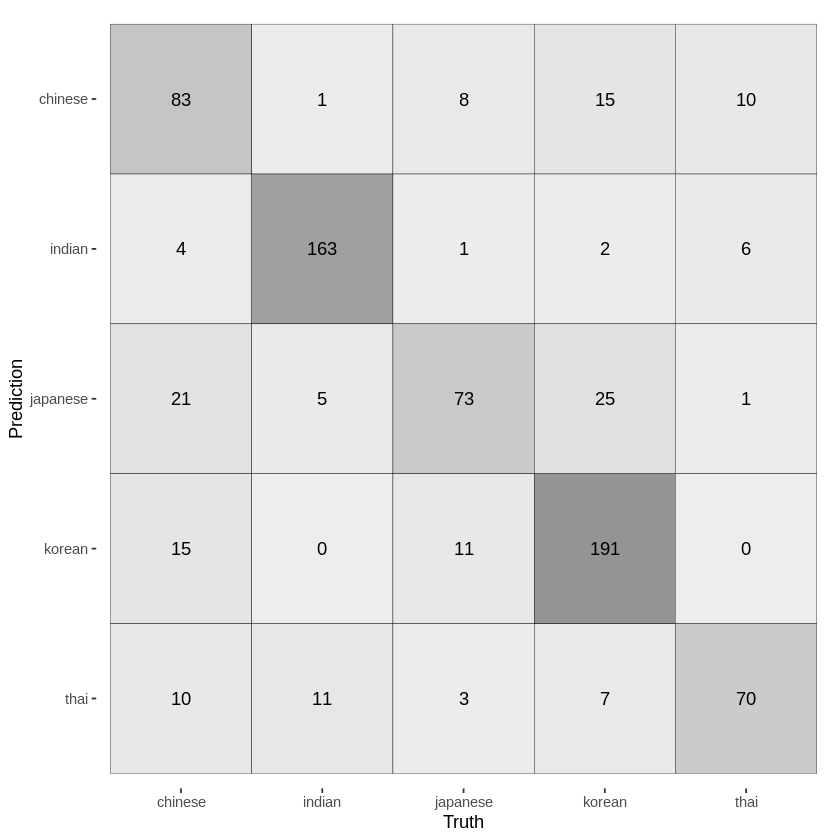

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Os quadrados mais escuros no gráfico da matriz de confusão indicam um número elevado de casos, e você deve conseguir observar uma linha diagonal de quadrados mais escuros, indicando os casos em que o rótulo previsto e o rótulo real são os mesmos.

Agora, vamos calcular as estatísticas resumidas para a matriz de confusão.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Se nos concentrarmos em algumas métricas como precisão, sensibilidade, ppv, não estamos indo mal para começar 🥳!

## 4. Explorando Mais a Fundo

Vamos fazer uma pergunta sutil: Quais critérios são usados para definir um tipo de culinária como o resultado previsto?

Bem, algoritmos de aprendizado de máquina estatísticos, como regressão logística, são baseados em `probabilidade`; então, o que realmente é previsto por um classificador é uma distribuição de probabilidade sobre um conjunto de resultados possíveis. A classe com a maior probabilidade é então escolhida como o resultado mais provável para as observações fornecidas.

Vamos ver isso em ação fazendo tanto previsões de classe rígidas quanto probabilidades.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

Muito melhor!

✅ Você pode explicar por que o modelo tem tanta certeza de que a primeira observação é tailandesa?

## **🚀Desafio**

Nesta lição, você usou seus dados limpos para construir um modelo de aprendizado de máquina capaz de prever uma culinária nacional com base em uma série de ingredientes. Reserve um tempo para explorar as [muitas opções](https://www.tidymodels.org/find/parsnip/#models) que o Tidymodels oferece para classificar dados e [outras maneiras](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) de ajustar uma regressão multinomial.

#### AGRADECIMENTOS A:

[`Allison Horst`](https://twitter.com/allison_horst/) por criar as ilustrações incríveis que tornam o R mais acolhedor e envolvente. Encontre mais ilustrações na sua [galeria](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) e [Jen Looper](https://www.twitter.com/jenlooper) por criarem a versão original deste módulo em Python ♥️

<br>
Eu até faria algumas piadas, mas não entendo muito de trocadilhos sobre comida 😅.

<br>

Feliz aprendizado,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**Aviso Legal**:  
Este documento foi traduzido utilizando o serviço de tradução por IA [Co-op Translator](https://github.com/Azure/co-op-translator). Embora nos esforcemos para garantir a precisão, esteja ciente de que traduções automatizadas podem conter erros ou imprecisões. O documento original em seu idioma nativo deve ser considerado a fonte autoritativa. Para informações críticas, recomenda-se a tradução profissional realizada por humanos. Não nos responsabilizamos por quaisquer mal-entendidos ou interpretações equivocadas decorrentes do uso desta tradução.
